In [1]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 5.7 MB/s eta 0:00:0000:01


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from opacus import PrivacyEngine
from torchvision.models import inception_v3, Inception_V3_Weights

In [3]:
# Définir le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Préparation des données CIFAR-10 avec redimensionnement adapté pour InceptionV3 (299x299)
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Création d'un déséquilibre de classes
class_sizes = {0: 5000, 1: 4500, 2: 4000, 3: 3000, 4: 2000, 5: 1000, 6: 800, 7: 700, 8: 600, 9: 500}
class_indices = {i: np.where(np.array(trainset.targets) == i)[0] for i in range(10)}
imbalanced_indices = np.concatenate([np.random.choice(class_indices[i], size, replace=False)
                                     for i, size in class_sizes.items()])
train_subset = Subset(trainset, imbalanced_indices)

# Vous pouvez augmenter la taille du batch pour améliorer la stabilité (surtout pour DP)
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(testset, batch_size=batch_size, shuffle=False)

# --- Création du modèle non-DP ---
# Important : désactiver l'auxiliary classifier pour InceptionV3
# Charger le modèle avec les poids pré-entraînés et désactiver aux_logits
model = inception_v3(weights=None, aux_logits=False)

# Charger manuellement les poids pré-entraînés
weights = Inception_V3_Weights.DEFAULT
state_dict = weights.get_state_dict(progress=True)
model.load_state_dict(state_dict, strict=False)  # Ne pas forcer les clés strictement

# Modifier la dernière couche pour adapter CIFAR-10 (10 classes)
model.fc = nn.Linear(2048, 10)

# Envoyer le modèle sur le bon device (GPU/CPU)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fonction d'entraînement générique
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)  # Retourne directement un tenseur car aux_logits=False
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(loader)

# Fonction d'évaluation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Évaluation par classe
def evaluate_per_class(model, loader):
    model.eval()
    correct = torch.zeros(10)
    total = torch.zeros(10)
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                total[labels[i]] += 1
                if predicted[i] == labels[i]:
                    correct[labels[i]] += 1
    return (correct / total * 100).cpu().numpy()

100%|██████████| 170M/170M [00:02<00:00, 65.7MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 228MB/s]  


# Non-DP model

In [ ]:
# --- Entraînement du modèle non-DP ---
num_epochs = 15
print("Entraînement du modèle non-DP")
for epoch in range(num_epochs):
    loss = train_model(model, train_loader, criterion, optimizer)
    acc = evaluate(model, test_loader)
    acc_per_class = evaluate_per_class(model, test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss:.4f} - Global Accuracy: {acc*100:.2f}%")
    for i, class_acc in enumerate(acc_per_class):
        print(f"  Classe {i}: {class_acc:.2f}%")

# DP- model

In [4]:
# --- Passage en mode DP ---
num_epochs = 15

# Libérer la mémoire GPU si nécessaire
torch.cuda.empty_cache()

# Fonction pour "geler" les BatchNorm (utile pour l'entraînement DP)
def freeze_batchnorm(model):
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.track_running_stats = False
            module.weight.requires_grad = False
            module.bias.requires_grad = False
            # On peut aussi choisir de remplacer BatchNorm par GroupNorm dans une version plus aboutie

# Création du modèle DP (idem, désactivation de aux_logits)
model_dp = inception_v3(weights=None, aux_logits=False)
weights = Inception_V3_Weights.DEFAULT
state_dict = weights.get_state_dict(progress=True)
model_dp.load_state_dict(state_dict, strict=False)  # Ne pas forcer les clés strictement
model_dp.fc = nn.Linear(2048, 10)
freeze_batchnorm(model_dp)  # Appliquer avant de passer sur le device
model_dp = model_dp.to(device)

optimizer_dp = optim.Adam(model_dp.parameters(), lr=0.001)
criterion_dp = nn.CrossEntropyLoss()

# Création du PrivacyEngine avec des paramètres adaptés
# Pour se rapprocher des réglages du papier, on peut essayer noise_multiplier=0.6 et max_grad_norm=1.0
privacy_engine = PrivacyEngine()

model_dp, optimizer_dp, train_loader_dp = privacy_engine.make_private(
    module=model_dp,
    optimizer=optimizer_dp,
    data_loader=train_loader,  # Vous pouvez utiliser le même loader ou en recréer un si nécessaire
    noise_multiplier=0.4,       # Ajusté pour avoir un ε raisonnable (< 10)
    max_grad_norm=1.2,
)

# Boucle d'entraînement DP
print("\nEntraînement du modèle DP")
for epoch in range(num_epochs):
    model_dp.train()
    running_loss = 0.0
    for images, labels in train_loader_dp:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer_dp.zero_grad()
        outputs = model_dp(images)
        loss = criterion_dp(outputs, labels)
        loss.backward()
        optimizer_dp.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader_dp)
    dp_acc = evaluate(model_dp, test_loader)
    dp_acc_per_class = evaluate_per_class(model_dp, test_loader)
    
    # Affichage de la perte, de l'exactitude et du coût de confidentialité
    epsilon = privacy_engine.get_epsilon(delta=1e-6)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} - DP Accuracy: {dp_acc*100:.2f}%")
    print(f"(ε = {epsilon:.2f}, δ = 1e-6)")
    for i, class_acc in enumerate(dp_acc_per_class):
        print(f"  Classe {i}: {class_acc:.2f}%")

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(



Entraînement du modèle DP


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch [1/10] - Loss: 2.1039 - DP Accuracy: 9.98%
(ε = 2.46, δ = 1e-6)
  Classe 0: 99.70%
  Classe 1: 0.10%
  Classe 2: 0.00%
  Classe 3: 0.00%
  Classe 4: 0.00%
  Classe 5: 0.00%
  Classe 6: 0.00%
  Classe 7: 0.00%
  Classe 8: 0.00%
  Classe 9: 0.00%


KeyboardInterrupt: 

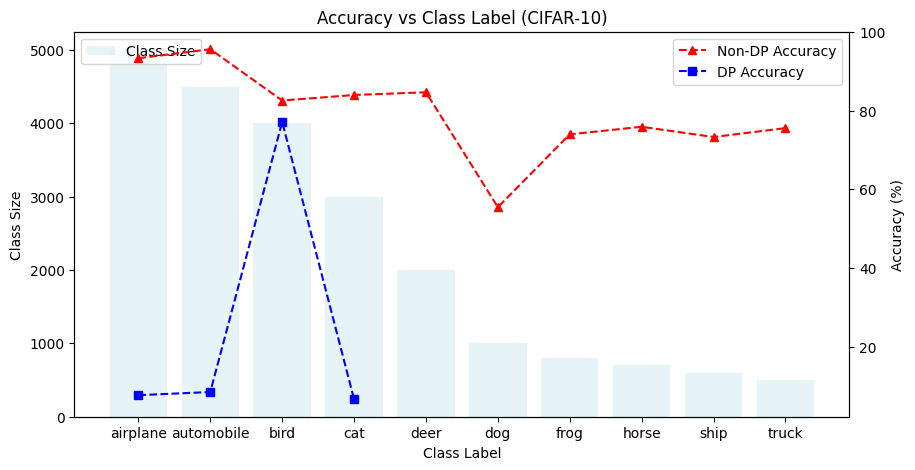

In [3]:
class_sizes = {
    "airplane": 5000, "automobile": 4500, "bird": 4000, "cat": 3000,
    "deer": 2000, "dog": 1000, "frog": 800, "horse": 700, "ship": 600, "truck": 500
}

accuracy_non_dp = {
    "airplane": [94.3, 91.1, 92.5, 92.2, 96.1, 93.1, 91.4, 94.7, 91.1, 95.5, 95.9, 92.3, 96.6, 91.0, 91.6],
    "automobile": [85.2, 91.1, 94.8, 95.8, 94.8, 98.1, 97.3, 94.9, 98.0, 98.1, 98.9, 96.3, 95.6, 97.5, 97.2],
    "bird": [69.5, 74.6, 70.7, 84.0, 87.7, 82.3, 83.3, 84.0, 84.0, 85.4, 83.9, 80.9, 88.1, 89.8, 90.0],
    "cat": [82.7, 69.2, 90.4, 88.5, 77.7, 82.0, 88.4, 83.5, 92.6, 84.9, 79.8, 88.4, 80.8, 80.0, 90.3],
    "deer": [55.1, 83.6, 88.1, 78.3, 87.2, 83.9, 88.2, 90.4, 91.5, 85.5, 92.8, 84.0, 89.7, 89.6, 81.7],
    "dog": [8.2, 55.6, 46.0, 53.1, 35.6, 59.3, 44.5, 46.6, 53.1, 70.6, 74.2, 80.1, 74.2, 71.9, 58.8],
    "frog": [44.3, 71.6, 53.1, 79.0, 80.8, 87.8, 89.3, 83.9, 57.7, 65.5, 89.3, 71.1, 79.2, 80.3, 76.4],
    "horse": [56.6, 77.3, 73.2, 67.8, 77.5, 72.3, 76.7, 88.0, 70.2, 82.1, 81.2, 67.7, 84.9, 79.2, 83.3],
    "ship": [28.7, 86.0, 42.2, 72.3, 78.0, 80.0, 72.7, 80.4, 71.8, 83.3, 77.3, 84.6, 78.7, 87.4, 75.7],
    "truck": [88.0, 26.7, 59.0, 74.9, 85.5, 73.4, 73.5, 84.1, 82.6, 84.1, 75.0, 88.6, 82.4, 76.1, 79.1]
}

accuracy_dp = {
    "airplane": [42.2, 0.1, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.9, 0.0, 0.0, 9.1, 0.0],
    "automobile": [67.7, 59.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    "bird": [0.0, 34.3, 0.0, 99.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 28.4, 100.0, 100.0, 94.1, 100.0],
    "cat": [0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
}

mean_accuracy_non_dp = {k: np.mean(v) for k, v in accuracy_non_dp.items()}
mean_accuracy_dp = {k: np.mean(v) for k, v in accuracy_dp.items()}

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Histogramme des tailles de classe
ax1.bar(list(class_sizes.keys()), list(class_sizes.values()), alpha=0.3, label='Class Size', color='lightblue')

# Lignes des accuracies
ax2.plot(list(mean_accuracy_non_dp.keys()), list(mean_accuracy_non_dp.values()), 'r--', marker='^', label='Non-DP Accuracy')
ax2.plot(list(mean_accuracy_dp.keys()), list(mean_accuracy_dp.values()), 'b--', marker='s', label='DP Accuracy')

# Axes et légendes
ax1.set_ylabel('Class Size')
ax2.set_ylabel('Accuracy (%)')
ax1.set_xlabel('Class Label')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Accuracy vs Class Label (CIFAR-10)')
plt.xticks(rotation=45)
plt.show()